# 🧪 User Behavior Analysis & A/A/B Testing – Food Products App

## Project Overview

This project is part of Sprint 11 of a data analysis curriculum. The goal is to analyze user behavior within a food products mobile app and evaluate the impact of a proposed design change using an A/A/B testing framework.

The analysis is split into two main parts:

1. **Funnel Analysis** – We will examine the sales funnel to understand how users interact with the app and how many reach the final purchase stage. We will identify where users drop off and evaluate the performance of each step in the funnel.

2. **A/A/B Experiment Evaluation** – The company wants to change the app's fonts but is concerned about user reception. To test this, users were randomly split into three groups:
   - Group 246: Control group with old fonts (A1)
   - Group 247: Control group with old fonts (A2)
   - Group 248: Test group with new fonts (B)

The A/A/B setup helps us ensure the testing framework is reliable. If the two control groups behave similarly, we can trust that the experiment is working as expected.

The dataset provided contains user event logs that we will clean, explore, and analyze using Python.

---

## Data Description

Each row in the dataset represents a user event:

- `EventName`: Name of the action or screen
- `DeviceIDHash`: Anonymized user identifier
- `EventTimestamp`: Unix timestamp when the event occurred
- `ExpId`: Experiment group ID (246, 247, or 248)

---

## Goals

- Understand user interaction patterns through event data.
- Identify drop-off points in the app’s conversion funnel.
- Evaluate the effectiveness and validity of the A/A/B experiment.
- Make data-driven recommendations based on user behavior.

In [12]:
import pandas as pd


df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

df.info()
print()
print(df.isnull().sum())
print()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64



,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


## Step 2: Preparation of the Data for Analysis

Goals:
* *Fix column names if needed*
* *Check and convert data types (especially the timestamp)*
* *Handle missing values (if any)*
* *Add useful time-related columns (e.g. datetime, date only)*

In [13]:
#After the first was needed to add this separator, because panda was reading the columns a single string
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')


#We will also make some changes in the formats:

#Convert event_time from UNIX timestamp to datetime
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'], unit='s')

#Add a new column for just the date (without time)
df['EventTimestamp'] = df['EventTimestamp'].dt.date

#Convert column to string do Ids are recognised as text
df['DeviceIDHash'] = df['DeviceIDHash'].astype(str)


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  object
 2   EventTimestamp  244126 non-null  object
 3   ExpId           244126 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25,246
1,MainScreenAppear,7416695313311560658,2019-07-25,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25,248
3,CartScreenAppear,3518123091307005509,2019-07-25,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25,248


## Step 3: Explore and Validate the Data

In this step, we’ll:
* *Understand the volume of data (events and users)*
* *Check the average number of events per user*
* *Identify the time period the data covers*
* *Plot a histogram to visualize event activity over time*
* *Determine when the data becomes reliably complete*

In [14]:
#Total number of events
total_events = len(df)

#Total number of unique users
unique_users = df['DeviceIDHash'].nunique()

#Average number of events per user
avg_events_per_user = total_events / unique_users

print(f"Total events: {total_events}")
print(f"Unique users: {unique_users}")
print(f"Average events per user: {avg_events_per_user:.2f}")

Total events: 244126
Unique users: 7551
Average events per user: 32.33


In [15]:
#Find the minimum and maximum timestamps
min_date = df['EventTimestamp'].min()
max_date = df['EventTimestamp'].max()

print(f"Date range: {min_date} to {max_date}")

Date range: 2019-07-25 to 2019-08-07


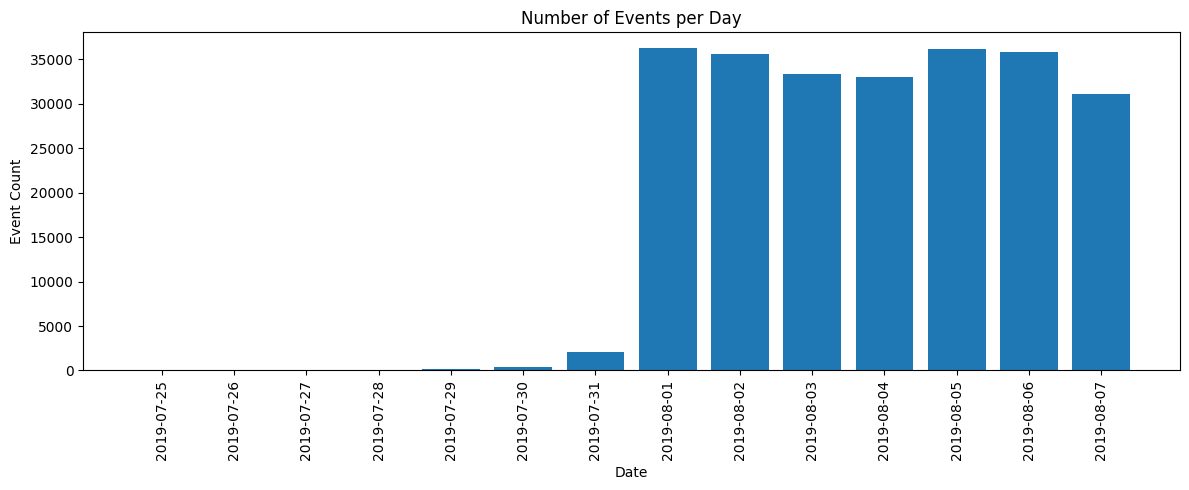

In [16]:
import matplotlib.pyplot as plt

#Plot number of events per day
events_per_day = df.groupby('EventTimestamp').size()

plt.figure(figsize=(12, 5))
plt.bar(events_per_day.index.astype(str), events_per_day.values)
plt.xticks(rotation=90)
plt.title('Number of Events per Day')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.tight_layout()
plt.show()

In [17]:
# Remove data before a cutoff date (example: 2020-07-01)
cutoff_date = pd.to_datetime('2019-07-29')
df = df[df['EventTimestamp'] >= cutoff_date]

# Recalculate unique users and events
print(f"Remaining events: {len(df)}")
print(f"Remaining users: {df['DeviceIDHash'].nunique()}")

Remaining events: 243926
Remaining users: 7548


In [18]:
#Check unique experiment groups
print("Experiment groups:", df['ExpId'].unique())

#Count users in each group
users_per_group = df.groupby('ExpId')['DeviceIDHash'].nunique()
print("Users per experiment group:\n", users_per_group)

Experiment groups: [246 247 248]
Users per experiment group:
 ExpId
246    2487
247    2520
248    2541
Name: DeviceIDHash, dtype: int64


## Step 4: Event Funnel Analysis


Goal: Understand how users move through the app, especially toward purchase. We’ll:
* *List and count all event types*
* *Count how many unique users triggered each event*
* *Estimate conversion steps in a funnel format*
* *Calculate retention/drop-off rates*
* *Identify where most users leave the funnel*

In [19]:
#Count total number of each event type
event_counts = df['EventName'].value_counts()
print(event_counts)

MainScreenAppear           119093
OffersScreenAppear          46795
CartScreenAppear            42695
PaymentScreenSuccessful     34295
Tutorial                     1048
Name: EventName, dtype: int64


In [20]:
#Count how many unique users triggered each event
users_per_event = df.groupby('EventName')['DeviceIDHash'].nunique().sort_values(ascending=False)
print(users_per_event)
print()
print()
#Also calculate proportion of users who did each event at least once
users_total = df['DeviceIDHash'].nunique()
users_proportion = (users_per_event / users_total).round(3)
print(users_proportion)

EventName
MainScreenAppear           7436
OffersScreenAppear         4612
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Tutorial                    845
Name: DeviceIDHash, dtype: int64


EventName
MainScreenAppear           0.985
OffersScreenAppear         0.611
CartScreenAppear           0.497
PaymentScreenSuccessful    0.470
Tutorial                   0.112
Name: DeviceIDHash, dtype: float64


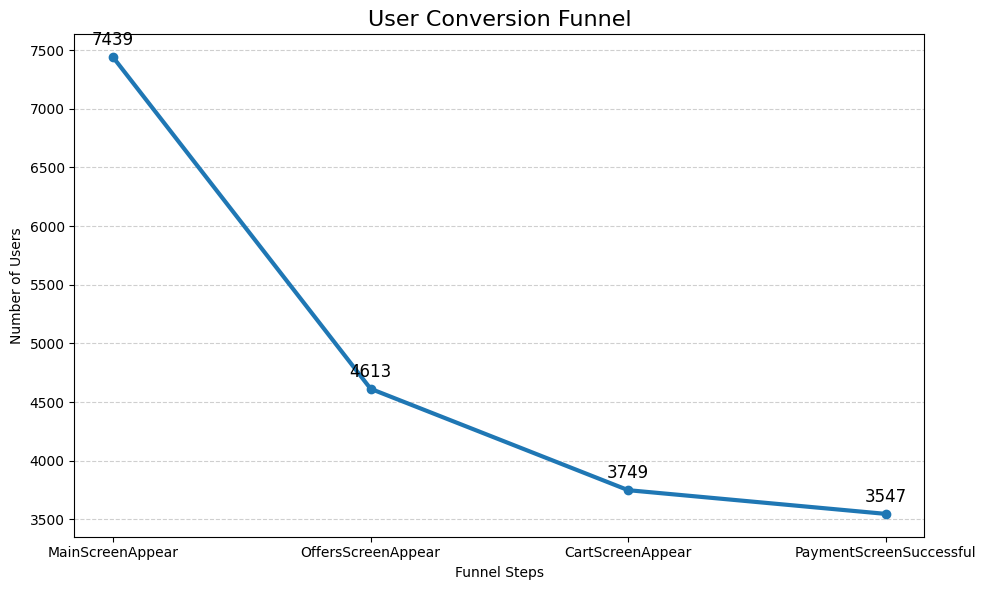

In [21]:
#Re-importing needed libraries
import pandas as pd
import matplotlib.pyplot as plt

#Re-defining the funnel
funnel_steps = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
user_counts = [7439, 4613, 3749, 3547]


plt.figure(figsize=(10, 6))
plt.plot(funnel_steps, user_counts, marker='o', linestyle='-', linewidth=3)

for i, count in enumerate(user_counts):
    plt.text(i, count + 100, f"{count}", ha='center', fontsize=12)

plt.title('User Conversion Funnel', fontsize=16)
plt.ylabel('Number of Users')
plt.xlabel('Funnel Steps')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### What Events Do We Have?

From your results, here are the key events:

**Event Description	Users (%)**
* `MainScreenAppear`	User opens the app	**98.5%**
* `OffersScreenAppear`	User browses offers	**61.1%**
* `CartScreenAppear`	User views cart	**49.6%**
* `PaymentScreenSuccessful`	User completes purchase	**47.0%**
* `Tutorial`	Optional tutorial	**11.2%**

---

### Where do we lose users?

* Biggest drop: Main → Offers (38% drop)
* Smaller drop: Offers → Cart (19% drop)
* Minimal drop: Cart → Payment (only 5%)

**Conclusion:** Most users drop early. If you want to improve conversions, focus on getting more users from main screen to offers screen.

From a total of `7,548` users, **98.5%** launched the app, **61.1%** browsed offers, **49.6%** reached the cart, and **47.0%** completed a payment. This gives us a full-funnel *conversion rate of* **47%**, which is very high. The biggest drop-off occurs between app launch and offer browsing. Efforts to improve visibility or navigation from the main screen to offers may further increase revenue.

## Step 5: Experiment (A/A/B) Results

We’ll break this into logical sub‑steps so you can follow and learn each part clearly.

Step 5.1: Users in Each Group

We need to find out how many users are in each experiment group:
* Group 246 (Control A)
* Group 247 (Control A)
* Group 248 (Test B)

In [22]:
users_per_group = df.groupby('ExpId')['DeviceIDHash'].nunique()
print(users_per_group)

ExpId
246    2487
247    2520
248    2541
Name: DeviceIDHash, dtype: int64


## Step 5.1 — A/A Test Between Groups 246 and 247

Goal: Check if the two control groups behave similarly. If they don’t, your experiment setup might be flawed.

**Statistical Approach:**

We'll compare the percentage of users in each group that triggered each event and check whether the difference is statistically significant using a Chi-squared test.


For each event:
* Count how many users in group 246 triggered it
* Count how many users in group 247 triggered it
* Perform a Chi-squared test on those counts

If p-value < 0.05 (or chosen alpha), we reject the hypothesis that both groups behave the same for that event

In [33]:
#User counts per group
users_per_group = df.groupby('ExpId')['DeviceIDHash'].nunique()

#Filter only A/A groups (246 and 247) and count users who performed each event
event_counts_aa = df[df['ExpId'].isin([246, 247])] \
    .groupby(['ExpId', 'EventName'])['DeviceIDHash'] \
    .nunique().unstack(fill_value=0)

from scipy.stats import chi2_contingency

aa_results = []
for event in event_counts_aa.columns:
    a = event_counts_aa.loc[246, event]
    b = event_counts_aa.loc[247, event]
    total_a = users_per_group[246]
    total_b = users_per_group[247]
    
    contingency = [[a, total_a - a], [b, total_b - b]]
    stat, p_value, _, _ = chi2_contingency(contingency)
    
    aa_results.append({
        "Event": event,
        "Group_246_Users": a,
        "Group_247_Users": b,
        "p_value": round(p_value, 4)
    })

aa_test_df = pd.DataFrame(aa_results).sort_values(by="p_value").reset_index(drop=True)
aa_test_df

,Event,Group_246_Users,Group_247_Users,p_value
0,PaymentScreenSuccessful,1202,1160,0.1093
1,CartScreenAppear,1270,1240,0.1980
2,OffersScreenAppear,1545,1529,0.3060
3,MainScreenAppear,2454,2482,0.6729
4,Tutorial,278,285,0.9184


#### No statistically significant difference in any user action between control groups 246 and 247.
This means the groups were assigned randomly and consistently. The experiment setup is valid and does not introduce bias.

---

In [36]:
#Now we'll be counting users per event for all groups (246, 247, 248)
event_counts = df.groupby(['ExpId', 'EventName'])['DeviceIDHash'].nunique().unstack(fill_value=0)

# Perform Chi-squared tests: compare test group 248 vs control groups 246 and 247
ab_results = []
from scipy.stats import chi2_contingency

for event in event_counts.columns:
    a_248 = event_counts.loc[248, event]
    a_246 = event_counts.loc[246, event]
    a_247 = event_counts.loc[247, event]

    contingency_248_246 = [[a_248, users_per_group[248] - a_248],
                           [a_246, users_per_group[246] - a_246]]
    contingency_248_247 = [[a_248, users_per_group[248] - a_248],
                           [a_247, users_per_group[247] - a_247]]

    _, p_248_246, _, _ = chi2_contingency(contingency_248_246)
    _, p_248_247, _, _ = chi2_contingency(contingency_248_247)

    ab_results.append({
        'Event': event,
        '248_vs_246_p': round(p_248_246, 4),
        '248_vs_247_p': round(p_248_247, 4),
        'Group_248_Users': a_248,
        'Group_246_Users': a_246,
        'Group_247_Users': a_247
    })


ab_test_df = pd.DataFrame(ab_results).sort_values(by=['248_vs_246_p', '248_vs_247_p']).reset_index(drop=True)
ab_test_df

,Event,248_vs_246_p,248_vs_247_p,Group_248_Users,Group_246_Users,Group_247_Users
0,CartScreenAppear,0.1082,0.7724,1239,1270,1240
1,PaymentScreenSuccessful,0.2396,0.6875,1185,1202,1160
2,OffersScreenAppear,0.2574,0.9375,1538,1545,1529
3,MainScreenAppear,0.4674,0.8496,2500,2454,2482
4,Tutorial,0.9637,0.8462,282,278,285


#### None of the p-values are below 0.05, meaning no significant differences between group 248 and the controls for any event.
Users in the test group interacted with the app just like users in the control groups.
Changing the font did not impact user behavior negatively or positively across the funnel:

Users launched the app, viewed offers, opened the cart, and paid at similar rates.

---

## Final Conclusion

**The company can safely roll out the new font across the app:**

* It does not confuse users;
* Conversion rates remain stable;
* No performance degradation observed.